# Оценка важности предварительной обработки данных

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

## 1. Загрузка данных

In [65]:
df = pd.read_csv('train.csv')
df.head(2)

PassengerId 
 Survived 
 Pclass 
 Name 
 Sex 
 Age 
 SibSp 
 Parch 
 Ticket 
 Fare 
 Cabin 
 Embarked 
 
 
 
 
 0 
 1 
 0 
 3 
 Braund, Mr. Owen Harris 
 male 
 22.0 
 1 
 0 
 A/5 21171 
 7.2500 
 NaN 
 S 
 
 
 1 
 2 
 1 
 1 
 Cumings, Mrs. John Bradley (Florence Briggs Th... 
 female 
 38.0 
 1 
 0 
 PC 17599 
 71.2833 
 C85 
 C

Посмотрим на представление данных в датасете

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [67]:
df.isnull().sum()  # Пропущенные значения

PassengerId 0
Survived 0
Pclass 0
Name 0
Sex 0
Age 177
SibSp 0
Parch 0
Ticket 0
Fare 0
Cabin 687
Embarked 2
dtype: int64

## 2. Обучение модели на необработанных данных.

Проведём минимальную необходимую обработку данных, которая позволит нам обучить модель:

### 1) Удалим все пропущенные значения

In [68]:
df1 = df.dropna()
df1.isnull().sum().sum()

0

Теперь в датасете нет пропущенных значений

### **Какой процент данных мы при этом потеряли?**
Оставшееся в df1 число строк поделим на исходное их количество в df:

In [69]:
round(100 * (1 - df.dropna().shape[0] / df.shape[0]), 2)

79.46

То есть, если отбросить все пропуски, мы потеряем почти ***80%*** данных - это *очень много*.

### 2) Удалим нечисловые признаки

In [70]:
df1 = df1.iloc[:, [1, 2, 5, 6, 7, 9]]

In [71]:
df1

Survived 
 Pclass 
 Age 
 SibSp 
 Parch 
 Fare 
 
 
 
 
 1 
 1 
 1 
 38.0 
 1 
 0 
 71.2833 
 
 
 3 
 1 
 1 
 35.0 
 1 
 0 
 53.1000 
 
 
 6 
 0 
 1 
 54.0 
 0 
 0 
 51.8625 
 
 
 10 
 1 
 3 
 4.0 
 1 
 1 
 16.7000 
 
 
 11 
 1 
 1 
 58.0 
 0 
 0 
 26.5500 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 871 
 1 
 1 
 47.0 
 1 
 1 
 52.5542 
 
 
 872 
 0 
 1 
 33.0 
 0 
 0 
 5.0000 
 
 
 879 
 1 
 1 
 56.0 
 0 
 1 
 83.1583 
 
 
 887 
 1 
 1 
 19.0 
 0 
 0 
 30.0000 
 
 
 889 
 1 
 1 
 26.0 
 0 
 0 
 30.0000 
 
 
 
 183 rows × 6 columns

Разделим выборку на признаки и метки

In [72]:
Y1 = df1['Survived']
X1 = df1.iloc[:, [1, 2, 3, 4, 5]]

In [73]:
X1.head(2)

Pclass 
 Age 
 SibSp 
 Parch 
 Fare 
 
 
 
 
 1 
 1 
 38.0 
 1 
 0 
 71.2833 
 
 
 3 
 1 
 35.0 
 1 
 0 
 53.1000

Для классификации будем использовать три алгоритма:
- метод опорных векторов;
- логистическую регрессию;
- случайный лес.

Сравнивать мы будем не эти методы между собой, а результаты каждого метода по двум выборкам: очищенной и "сырой".

In [74]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [75]:
# Создадим три класса
models = [
    svm.SVC(kernel='linear'), 
    LogisticRegression(C=100.0, random_state=42, max_iter=500), 
    RandomForestClassifier(random_state=42, n_estimators=200)
]

В качестве метрик будем использовать *accuracy*.

Напишем функцию, которая позволит дважды обучить по три разных модели.

In [76]:
def calculate_scores(model_list, x, y):
    """ Функция для обучения трёх моделей """

    # Разделим датасет на тестовую и обучающую выборки
    X_train, X_test, Y_train, Y_test = train_test_split(
        x, y, test_size=0.2, random_state=42)
    score_list = []
    for model in model_list:
        model.fit(X=X_train, y=Y_train)  # Обучаем модель
        score_list.append(model.score(X_test, Y_test))  # Считаем accuracy
    return score_list

In [77]:
# Посчитаем точность для необработанных данных
hasty_scores = calculate_scores(models, X1, Y1)

In [78]:
hasty_scores

[0.6216216216216216, 0.7027027027027027, 0.6486486486486487]

## 3. Обработка и очистка данных

Теперь преобразуем данные - так алгоритмы лучше справятся с классификацией данных.

### 1) Анализ данных

Первым делом посмотрим на графическое представление признаков.

- **Мужчины и женщины**

Text(0.5, 1.0, 'Выживаемость пассажиров в зависимости от пола')

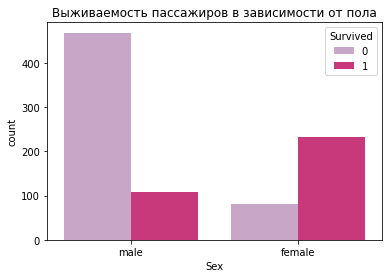

In [79]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df['Sex'], hue=df['Survived'], palette="PuRd")
plt.title('Выживаемость пассажиров в зависимости от пола')

Видим, что большая часть пассажиров - мужчины, при этом женщин выжило намного больше. У женщин шанс выжить был больше.

- **Класс комфортности**

Text(0.5, 1.0, 'Выживаемость пассажиров в зависимости от класса')

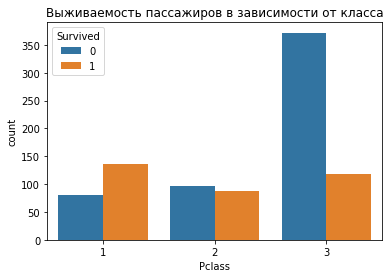

In [80]:
sns.countplot(x=df['Pclass'], hue=df['Survived'])
plt.title('Выживаемость пассажиров в зависимости от класса')

Видим, что среди пассажиров первого класса большинство выжили. Большая часть пассажиров путешествовали в третьем классе, и подавляющее большинство в третьем классе погибли.

- **Возраст**

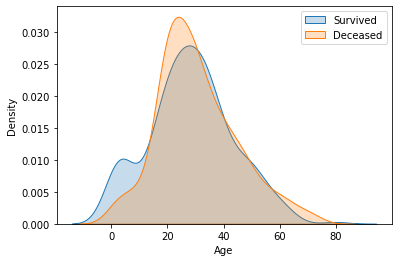

In [81]:
sns.kdeplot(df[df["Survived"]==1].Age, fill=True)
sns.kdeplot(df[df["Survived"]==0].Age, fill=True)
plt.legend(["Survived","Deceased"])

Как видим, среди детей много выживших (что подтверждается исторически), однако в целом возраст не очень коррелирует с выживаемостью: чем больше было пассажиров определённого возраста, тем больше среди них и погибших.

Проверим, есть ли выбросы

<AxesSubplot:xlabel='Age'>

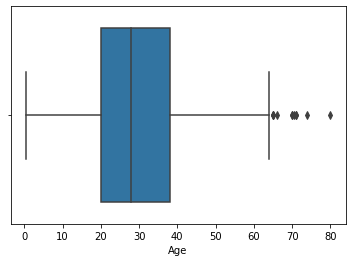

In [82]:
sns.boxplot(x = df['Age'])

Выбросы есть, но данные о возрасте скорее всего соответствуют действительности. Оставим их

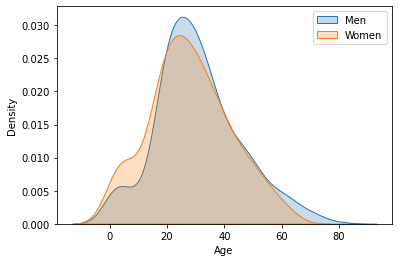

In [83]:
sns.kdeplot(df[df["Sex"]=='male'].Age, fill=True, palette="PuRd")
sns.kdeplot(df[df["Sex"]=='female'].Age, fill=True)
plt.legend(["Men","Women"])

Распределение возраста среди мужчин и женщин очень похоже, что подтверждает его слабое влияние на выживаемость.

- **Цена билета Fare**

Разобьём цену билета (стобец Fare) на четыре категории - по квартилям. Для этого узнаем значения квартилей

In [84]:
df['Fare'].describe()

count 891.000000
mean 32.204208
std 49.693429
min 0.000000
25% 7.910400
50% 14.454200
75% 31.000000
max 512.329200
Name: Fare, dtype: float64

Text(0.5, 1.0, 'Корреляция выживаемости и цены билета')

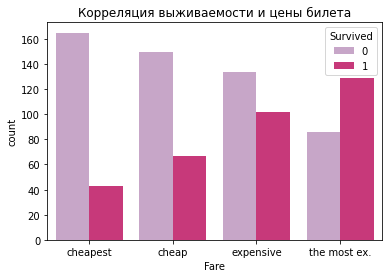

In [85]:
# Делим значения столбца на четыре группы
data = pd.cut(df['Fare'], bins=[0,7.91,14.45,31.28,513], labels=['cheapest','cheap','expensive', 'the most ex.'], right = True)
sns.countplot(x=data, hue=df['Survived'], palette="PuRd")
plt.title('Корреляция выживаемости и цены билета')

Видим чёткую корреляцию - чем больше пассажир заплатил за билет, тем выше были его шансы выжить. 

Также обратим внимание на то, что максимальное значение (512) сильно отличается от 75-го перцентиля. Похоже на выброс

<AxesSubplot:xlabel='Fare'>

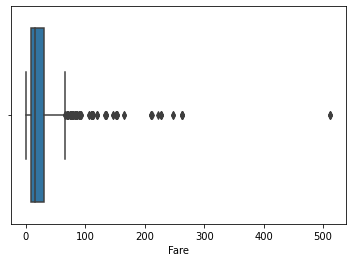

In [86]:
sns.boxplot(x = df['Fare'])

Билеты дороже 500 и правда являются выбросами относительно других данных, даже если это достоверные значения. Проверим, сколько их.

In [87]:
df[df['Fare'] > 500]

PassengerId 
 Survived 
 Pclass 
 Name 
 Sex 
 Age 
 SibSp 
 Parch 
 Ticket 
 Fare 
 Cabin 
 Embarked 
 
 
 
 
 258 
 259 
 1 
 1 
 Ward, Miss. Anna 
 female 
 35.0 
 0 
 0 
 PC 17755 
 512.3292 
 NaN 
 C 
 
 
 679 
 680 
 1 
 1 
 Cardeza, Mr. Thomas Drake Martinez 
 male 
 36.0 
 0 
 1 
 PC 17755 
 512.3292 
 B51 B53 B55 
 C 
 
 
 737 
 738 
 1 
 1 
 Lesurer, Mr. Gustave J 
 male 
 35.0 
 0 
 0 
 PC 17755 
 512.3292 
 B101 
 C

Три пассажира. Эти данные могут сильно повлиять на результат обучения - отбросим их.

In [88]:
df = df[df['Fare'] < 500]

- **Родственные узы**

Признаки SibSp и Parch отвечают за количество различных родственников; для простоты их можно объединить в один:

In [89]:
df['Family'] = df['Parch'] + df['SibSp']  # Далее проверим, есть ли корреляция

<AxesSubplot:xlabel='Family', ylabel='count'>

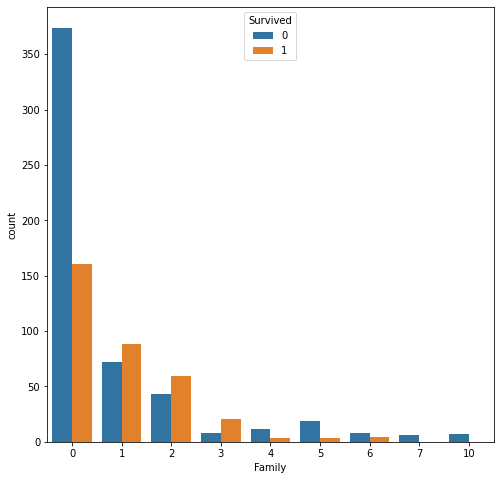

In [90]:
plt.figure(figsize=(8,8))
sns.countplot(x=df['Family'], hue=df['Survived'])

Видим, что если у пассажира более 3 родственников, то его шансы на выживание резко падают. Признак Family оставим для обучения модели, а два производных признака отбросим.

- **Пункт посадки**

Столбец Embarked отвечает на место, в котором пассажиры садились на борт и начинали путешествие. В этом столбце всего два пропущенных значения; отбросим их и проверим, есть ли корреляция.

Text(0.5, 1.0, 'Связь между выживаемостью и пунктом посадки')

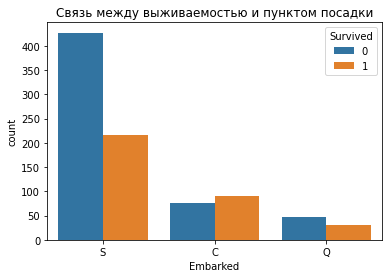

In [91]:
sns.countplot(x=df['Embarked'].dropna(), hue=df['Survived'])
plt.title('Связь между выживаемостью и пунктом посадки')

Пассажиры, которые сели в городе Cherbourg, имели больший шанс выжить. За счёт чего - непонятно, но статистика есть статистика, отбрасывать признак не будем - для него позже используем get_dummies. 

- **Распределение выживших по палубам**

Проверим, как на выживаемость каждого пассажира повлияла его каюта; в этом столбце очень много пропущенных значений, однако он может оказаться полезным.
Каюта обозначается комбинацией буквы и цифр, где буква отвечает за палубу, в которой находились каюты. У некоторых людей указано несколько кают - скорее всего, эти люди покупали билеты ещё и за членов семьи или других людей. 
Для анализа мы возьмём только палубы - всего их восемь.

Заменим полное описание только названием палубы (если указано несколько кают, палуба обычно совпадает, т.к. человек покупает билеты на соседние каюты), для этого мы извлечём первую букву из каждой строки.

<AxesSubplot:xlabel='Cabin', ylabel='count'>

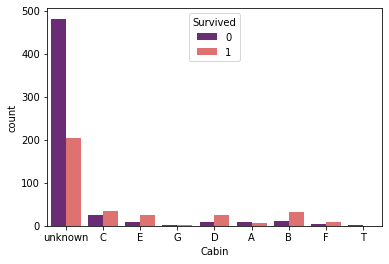

In [92]:
df['Cabin'] = df['Cabin'].apply(
    # Берём первый символ, если это не None;
    lambda x: x[0] if type(x) == str else 'unknown')  # Иначе вставляем отдельное значение

sns.countplot(
    x=df['Cabin'],
    hue=df['Survived'], 
    palette="magma"
)

Теперь повторим график, но без *unknown*, чтобы получше разглядеть остальное 

<AxesSubplot:xlabel='Cabin', ylabel='count'>

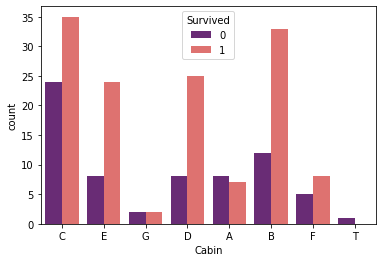

In [93]:
known_df = df[df['Cabin'] != 'unknown']
sns.countplot(x=known_df['Cabin'], hue=known_df['Survived'], palette="magma")

Какой вывод напрашивается? Выживаемость распределена по палубам случайно, однако подтверждается очевидное: если известна каюта пассажира, то вероятность его спасения выше. 
Отбрасывать этот признак не будем: теперь у нас есть отдельное значение для None, и с помощью get_dummies мы разобьём этот признак на отдельные столбцы - один из них будет означать, что признак пропущен.

### 2) Удаление ненужных признаков

- Отбросим данные, которые не несут для модели смысловой нагрузки: это имя человека и его порядковый номер.
- Столбец Tickets модель так же не сможет интерпретировать, поэтому его тоже удалим.
- Столбцы SibSp и Parch удаляем, потому что используем Family

In [94]:
df = df.iloc[:, [1, 2, 4, 5, 9, 10, 11, 12]]
df.head(2)

Survived 
 Pclass 
 Sex 
 Age 
 Fare 
 Cabin 
 Embarked 
 Family 
 
 
 
 
 0 
 0 
 3 
 male 
 22.0 
 7.2500 
 unknown 
 S 
 1 
 
 
 1 
 1 
 1 
 female 
 38.0 
 71.2833 
 C 
 C 
 1

### 3) Заполнение пропусков и обработка категориальных признаков

- Пол

В столбце Sex строковые значения заменим бинарными:

In [95]:
df['Sex'] = df['Sex'].apply(lambda x: 1 if x == 'male' else 0)

- Age & Embarked

Пропуски заполним *модой*, т.е. наиболее популярным значением.

In [96]:
df['Age'] = df['Age'].fillna(df.Age.mode()[0])

df['Embarked'] = df['Embarked'].fillna(df.Embarked.mode()[0])

- Теперь для *Cabin*, *Embarked* и *Pclass* применим One-Hot Encoding

In [97]:
df = pd.get_dummies(df, columns=['Cabin', 'Embarked', 'Pclass'], drop_first=True, dummy_na=False, dtype='int')
df.head(2)

Survived 
 Sex 
 Age 
 Fare 
 Family 
 Cabin_B 
 Cabin_C 
 Cabin_D 
 Cabin_E 
 Cabin_F 
 Cabin_G 
 Cabin_T 
 Cabin_unknown 
 Embarked_Q 
 Embarked_S 
 Pclass_2 
 Pclass_3 
 
 
 
 
 0 
 0 
 1 
 22.0 
 7.2500 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 1 
 0 
 1 
 0 
 1 
 
 
 1 
 1 
 0 
 38.0 
 71.2833 
 1 
 0 
 1 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0 
 0

## 4. Обучение модели на подготовленных данных

Теперь получим предсказания ещё раз

In [98]:
X = df.loc[:, df.columns != 'Survived']

In [99]:
Y = df['Survived']

In [100]:
# Обнулим наши модели и обучим их заново
models = [
    svm.SVC(kernel='linear'), 
    LogisticRegression(C=1.0, random_state=42, max_iter=900), 
    RandomForestClassifier(random_state=42, n_estimators=200)
]

In [101]:
# Теперь посчитаем точность для более качественной модели
well_done_scores = calculate_scores(models, X, Y)

## 5. Оценка и сравнение результатов

Представим результаты в виде таблицы (дафрейма)

In [102]:
results = np.array([
    # 'Method': model_names,
    ['Unprepared', *hasty_scores],
    ['Well prepared', *well_done_scores],
])

In [103]:
pd.DataFrame(results, columns=['data', 'SVM', 'Log Regression', 'Random Forest']).set_index('data')

SVM 
 Log Regression 
 Random Forest 
 
 
 data 
 
 
 
 
 
 
 
 Unprepared 
 0.6216216216216216 
 0.7027027027027027 
 0.6486486486486487 
 
 
 Well prepared 
 0.8202247191011236 
 0.8370786516853933 
 0.8314606741573034

## 6. Выводы

В ходе этой работы мы обучили три разные модели на датасете "Титаник", причём сперва мы использовали неочищенный, "сырой" датасет, а затем проанализировали данные, подготовили их вручную и обучили модели снова.

В ходе обработки датасета:
- были проанализированы и удалены выбросы;
- пропущенные в некоторых столбцах данные были заполнены с помощью анализа не пустых значений - это позволило использовать практически в **5 раз** больше данных для обучения;
- категориальные признаки были преобразованы с помощью One Hot Encoding и замены на бинарные значения.

### В итоге:

Имея точность до 70% на необработанных данных, мы смогли получить не менее 82% при использовании обработанного датасета. Каждый из трёх использованных методов намного лучше справился с классификацией, когда модель получала на вход очищенные данные: прирост точности составил 19-31%.

Вне сомнений, обработка данных идёт на пользу при построении моделей машинного обучения: она позволяет использовать больше наблюдений для обучения, снизить негативное воздействие аномальных значений на обучение, использовать больше признаков и корректно их интерпретировать.